#  Vision Transformer preprocessing techniques
In this ipynb I test various ways to preprocess the images in order to bring them to a reasonable size to train a quantum model. I used mean pooling, max pooling and PCA.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D

print("Default GPU Device: {}".format(tf.test.gpu_device_name()))

2024-06-04 13:58:38.925071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 13:58:39.490652: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-04 13:58:39.490674: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-04 13:58:41.928607: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Default GPU Device: 


2024-06-04 13:58:44.511321: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 13:58:45.654557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 13:58:45.655361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-04 13:58:45.655804: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.

In [2]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    # Compute the grid size needed (square root of num_images, rounded up)
    grid_size = 5

    # Set up the figure
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

In [3]:
# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Expand the dimensions and convert to float32: from (60000, 28, 28) to (60000, 28, 28, 1)
train_images = train_images.reshape((-1, 28, 28, 1)).astype('float32')
test_images = test_images.reshape((-1, 28, 28, 1)).astype('float32')

# Normalize the images to the range 0-1 (optional but recommended)
train_images /= 255.0
test_images /= 255.0

# Define the average pooling operation
pool_size = (7, 7)
strides = (7, 7)
avg_pool_layer = AveragePooling2D(pool_size=pool_size, strides=strides)

# Apply average pooling
pooled_train_images_avg = avg_pool_layer(train_images)
pooled_test_images_avg = avg_pool_layer(test_images)

max_pool_layer = MaxPooling2D(pool_size=pool_size, strides=strides)

# Apply max pooling
pooled_train_images_max = max_pool_layer(train_images)
pooled_test_images_max = max_pool_layer(test_images)

2024-06-04 13:58:47.404580: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 13:58:47.405188: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


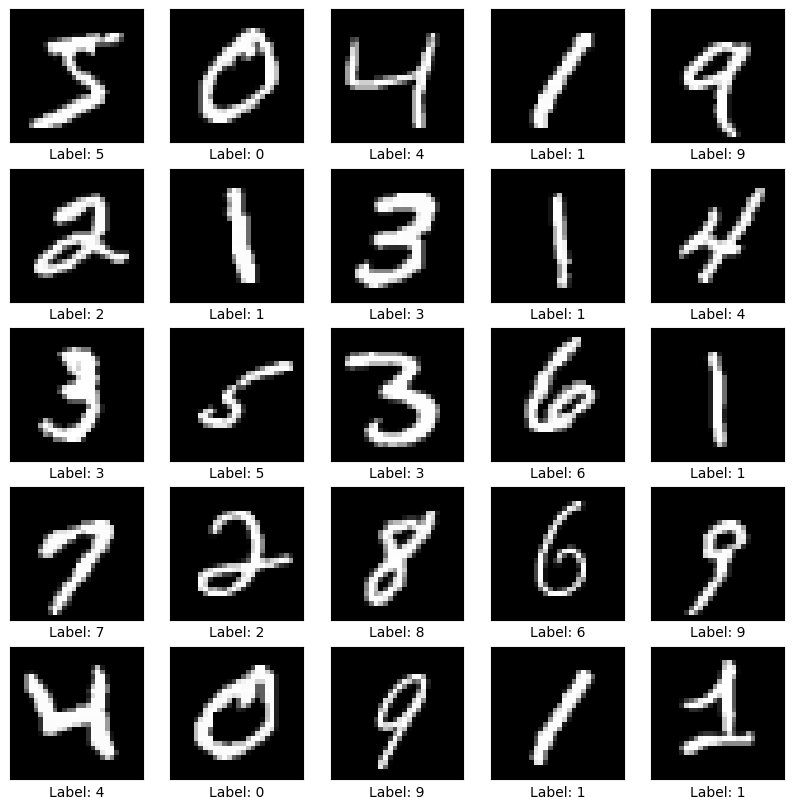

In [4]:
#Plot some of the images with their labels
plot_images(train_images, train_labels, num_images=25, figsize=(10,10))

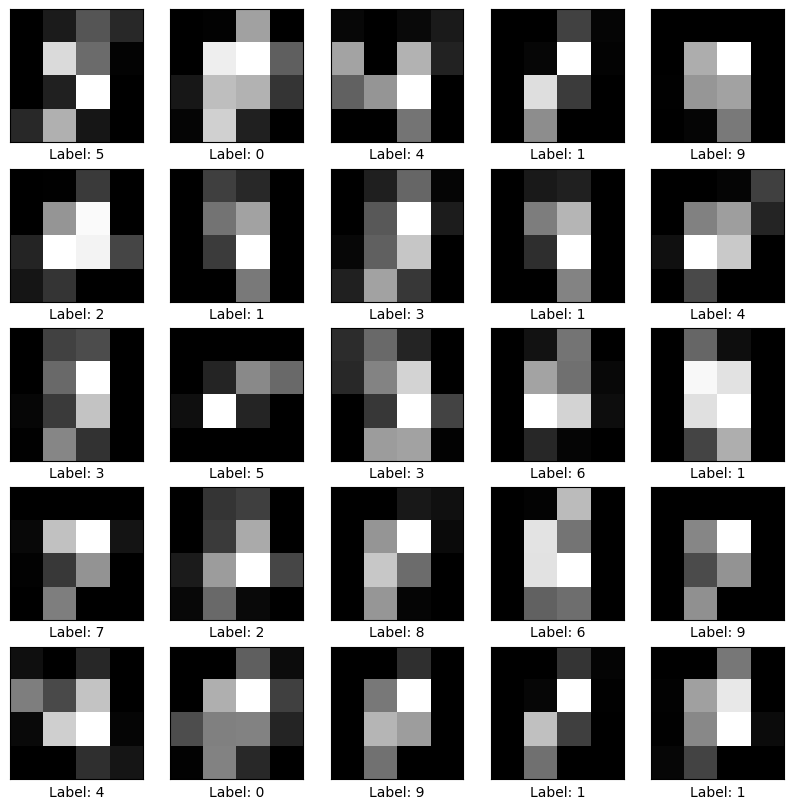

In [5]:
#Plot some of the images with their labels
plot_images(pooled_train_images_avg, train_labels, num_images=25, figsize=(10,10))

In [6]:
# Expand the dimensions of the images to (28, 28, 1) to represent the grayscale channel explicitly
train_images_pooled = np.expand_dims(train_images, -1)
test_images_pooled = np.expand_dims(test_images, -1)

# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [7]:
class PatchExtractor(Layer):
    def __init__(self, patch_size=2):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size  # Initialize patch size

    def call(self, images):
        # Calculate the batch size from the images tensor
        batch_size = tf.shape(images)[0]
        # Extract patches from images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Size of patches to extract
            strides=[1, self.patch_size, self.patch_size, 1],  # Stride for each patch
            rates=[1, 1, 1, 1],  # Dilation rate, set to 1 meaning no dilation
            padding="VALID",  # Use valid padding, no padding is applied
        )
        # Reshape the patches to have the patch dimension flattened
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

In [8]:
image = pooled_train_images_avg[0]  # Select the first image of the dataset
batch = tf.expand_dims(image, 0)  # Adds the batch dimension
# Now use PatchExtractor
patches = PatchExtractor(patch_size=2)(batch)

patches.shape

TensorShape([1, 4, 4])

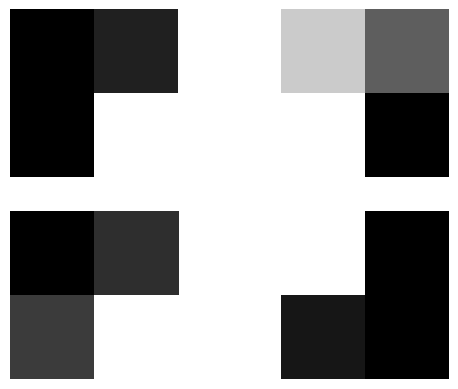

In [9]:
# Calculate the number of patches per side (sqrt) to organize the subplot grid
n = int(np.sqrt(patches.shape[1]))

# Visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Since the patch is flattened, we reshape it back to its original size (4x4 here), and there's only one channel for grayscale
    patch_img = tf.reshape(patch, (2, 2))
    ax.imshow(patch_img.numpy(), cmap='gray')
    ax.axis("off")

plt.show()

In [10]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=4, projection_dim=2*2):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches  # Total number of patches
        self.projection_dim = projection_dim  # Dimension to project each patch onto
        # Initialize weights for the class token
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(initial_value=w_init(shape=(1, projection_dim), dtype="float32"), trainable=True)
        self.projection = Dense(units=projection_dim)  # Dense layer to project patch features
        self.position_embedding = Embedding(input_dim=num_patches + 1, output_dim=projection_dim)  # Positional embeddings

    def call(self, patches):
        batch_size = tf.shape(patches)[0]  # Calculate the batch size
        # Repeat the class token for each item in the batch
        class_token = tf.tile(self.class_token, multiples=[batch_size, 1])
        class_token = tf.reshape(class_token, (batch_size, 1, self.projection_dim))
        # Project the patches to the specified dimension
        patches_embed = self.projection(patches)
        # Concatenate the class token with the projected patches
        patches_embed = tf.concat([class_token, patches_embed], axis=1)
        # Calculate positional embeddings for all patches + class token
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positional embeddings to the concatenated embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [11]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 5, 4])

In [12]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        # First dense layer with GELU activation
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        # Second dense layer for output features
        self.dense2 = Dense(out_features)
        # Dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Apply first dense layer
        x = self.dense1(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply second dense layer
        x = self.dense2(x)
        # Apply dropout again
        y = self.dropout(x)
        return y

mlp = MLP(4*2, 4)
y = mlp(tf.zeros((1, 5, 4)))
y.shape

TensorShape([1, 5, 4])

In [13]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        # First layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-6)
        # Multi-head attention layer
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        # Second layer normalization
        self.norm2 = LayerNormalization(epsilon=1e-6)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply multi-head attention
        attention_output = self.attn(x1, x1)
        # Add residual connection after attention
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection after MLP
        y = Add()([x3, x2])
        return y

block = Block(4)
y = block(tf.zeros((1, 5, 4)))
y.shape

TensorShape([1, 5, 4])

In [14]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=3, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(0.1)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

transformer = TransformerEncoder(4)
y = transformer(embeddings)
y.shape

TensorShape([1, 5, 4])

In [15]:
def create_VisionTransformer(num_classes, num_patches=4, projection_dim=2*2, input_shape=(4, 4, 1)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='softmax')(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model
model = create_VisionTransformer(10)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4, 1)]         0         
                                                                 
 patch_extractor_1 (PatchExt  (None, None, 4)          0         
 ractor)                                                         
                                                                 
 patch_encoder_1 (PatchEncod  (None, 5, 4)             44        
 er)                                                             
                                                                 
 transformer_encoder_1 (Tran  (None, 5, 4)             1208      
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d (G  (None, 4)                0         
 lobalAveragePooling1D)                                      

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [17]:
history = model.fit(
    pooled_train_images_avg, train_labels,
    epochs=4,
    batch_size=32,
    validation_data=(pooled_test_images_avg, test_labels)
)

Epoch 1/4
1875/1875 [==============================] - 56s 23ms/step - loss: 1.9109 - accuracy: 0.3002 - auc: 0.7594 - val_loss: 1.5619 - val_accuracy: 0.4579 - val_auc: 0.8619
Epoch 2/4
1875/1875 [==============================] - 41s 22ms/step - loss: 1.5108 - accuracy: 0.4629 - auc: 0.8675 - val_loss: 1.3697 - val_accuracy: 0.5225 - val_auc: 0.8946
Epoch 3/4
1875/1875 [==============================] - 41s 22ms/step - loss: 1.4229 - accuracy: 0.4969 - auc: 0.8841 - val_loss: 1.3182 - val_accuracy: 0.5234 - val_auc: 0.9015
Epoch 4/4
1875/1875 [==============================] - 41s 22ms/step - loss: 1.3660 - accuracy: 0.5059 - auc: 0.8938 - val_loss: 1.3012 - val_accuracy: 0.5295 - val_auc: 0.9046


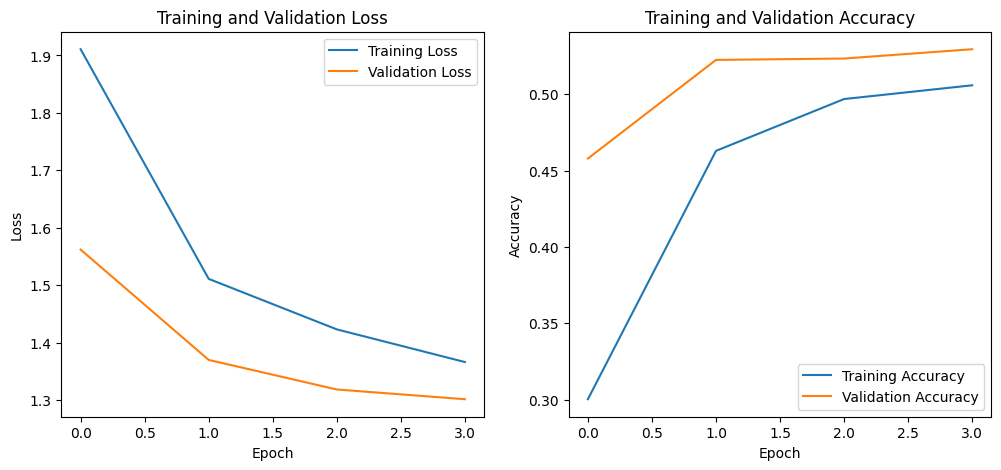

In [18]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [19]:
model = create_VisionTransformer(10)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4, 4, 1)]         0         
                                                                 
 patch_extractor_2 (PatchExt  (None, None, 4)          0         
 ractor)                                                         
                                                                 
 patch_encoder_2 (PatchEncod  (None, 5, 4)             44        
 er)                                                             
                                                                 
 transformer_encoder_2 (Tran  (None, 5, 4)             1208      
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_1   (None, 4)                0         
 (GlobalAveragePooling1D)                                  

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [21]:
history = model.fit(
    pooled_train_images_max, train_labels,
    epochs=4,
    batch_size=32,
    validation_data=(pooled_test_images_max, test_labels)
)

Epoch 1/4
1875/1875 [==============================] - 65s 28ms/step - loss: 2.0557 - accuracy: 0.2321 - auc: 0.7079 - val_loss: 1.8441 - val_accuracy: 0.3258 - val_auc: 0.7890
Epoch 2/4
1875/1875 [==============================] - 49s 26ms/step - loss: 1.8289 - accuracy: 0.3332 - auc: 0.7883 - val_loss: 1.6744 - val_accuracy: 0.3868 - val_auc: 0.8323
Epoch 3/4
1875/1875 [==============================] - 45s 24ms/step - loss: 1.7187 - accuracy: 0.3726 - auc: 0.8202 - val_loss: 1.5975 - val_accuracy: 0.4050 - val_auc: 0.8499
Epoch 4/4
1875/1875 [==============================] - 46s 25ms/step - loss: 1.6741 - accuracy: 0.3907 - auc: 0.8327 - val_loss: 1.5332 - val_accuracy: 0.4404 - val_auc: 0.8653


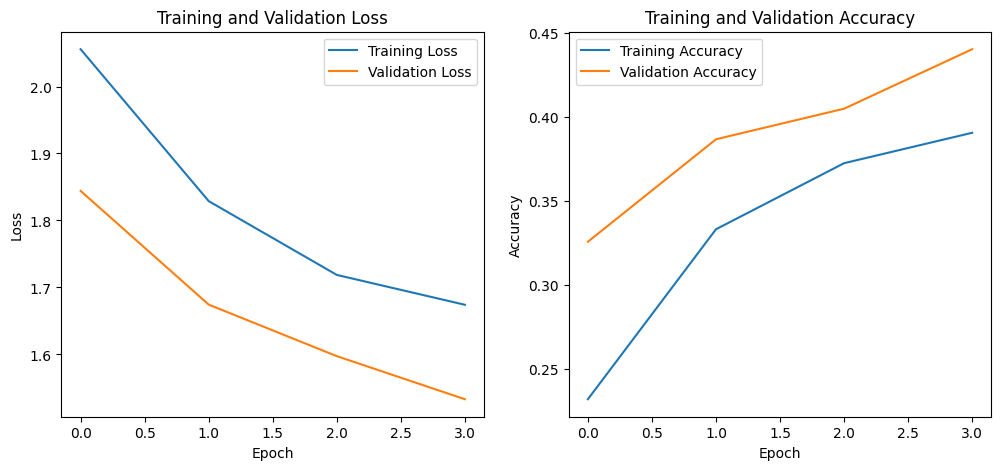

In [22]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
from sklearn.decomposition import PCA

# Reshape the images from 28x28 to a flat array of 784 per image
train_images_flat = train_images.reshape((-1, 28*28))
test_images_flat = test_images.reshape((-1, 28*28))

# Apply PCA to reduce dimensions to 16
pca = PCA(n_components=16)
pca_train_images = pca.fit_transform(train_images_flat)
pca_test_images = pca.transform(test_images_flat)

# Reshape the PCA output to (4, 4, 60000)
pca_train_images = pca_train_images.reshape(-1, 4, 4, 1)
pca_test_images = pca_test_images.reshape(-1, 4, 4, 1)

# Check the new shape of the transformed data
print("New shape of train images after PCA:", pca_train_images.shape)  # Should be ( 4, 4, 60000)
print("New shape of test images after PCA:", pca_test_images.shape)

New shape of train images after PCA: (60000, 4, 4, 1)
New shape of test images after PCA: (10000, 4, 4, 1)


In [24]:
model = create_VisionTransformer(10)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 4, 4, 1)]         0         
                                                                 
 patch_extractor_3 (PatchExt  (None, None, 4)          0         
 ractor)                                                         
                                                                 
 patch_encoder_3 (PatchEncod  (None, 5, 4)             44        
 er)                                                             
                                                                 
 transformer_encoder_3 (Tran  (None, 5, 4)             1208      
 sformerEncoder)                                                 
                                                                 
 global_average_pooling1d_2   (None, 4)                0         
 (GlobalAveragePooling1D)                                  

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [26]:
history = model.fit(
    pca_train_images, train_labels,
    epochs=4,
    batch_size=32,
    validation_data=(pca_test_images, test_labels)
)

Epoch 1/4
1875/1875 [==============================] - 56s 21ms/step - loss: 1.9815 - accuracy: 0.2828 - auc: 0.7458 - val_loss: 1.6598 - val_accuracy: 0.4451 - val_auc: 0.8414
Epoch 2/4
1875/1875 [==============================] - 39s 21ms/step - loss: 1.5448 - accuracy: 0.4811 - auc: 0.8605 - val_loss: 1.2103 - val_accuracy: 0.6022 - val_auc: 0.9188
Epoch 3/4
1875/1875 [==============================] - 39s 21ms/step - loss: 1.2125 - accuracy: 0.5951 - auc: 0.9173 - val_loss: 0.9916 - val_accuracy: 0.6707 - val_auc: 0.9449
Epoch 4/4
1875/1875 [==============================] - 37s 20ms/step - loss: 1.0905 - accuracy: 0.6329 - auc: 0.9328 - val_loss: 0.9285 - val_accuracy: 0.6957 - val_auc: 0.9509


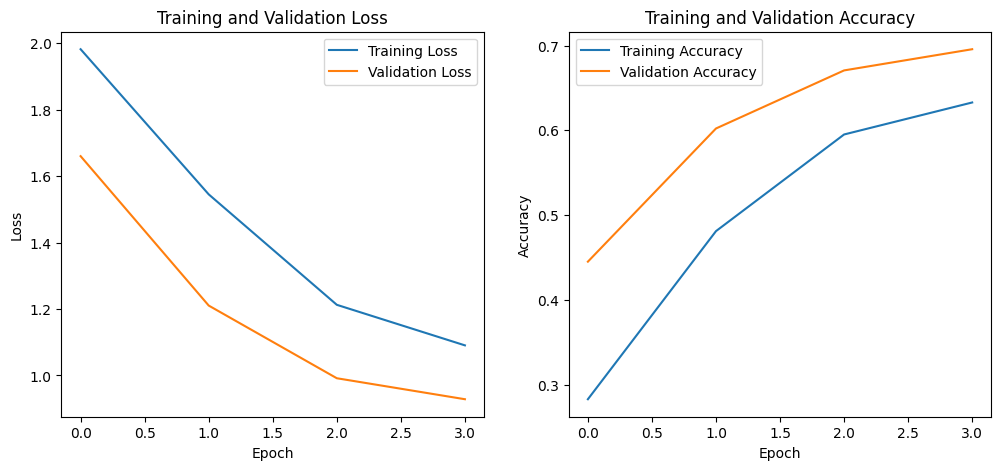

In [27]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()